In [3]:
import fastai; fastai.__version__

'1.0.46.dev0'

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import string

# create data

In [5]:
# path = untar_data(URLs.PETS, dest='/data/fastai/')
path = untar_data(URLs.PETS, dest='~/data/fastai/')

path.ls()

[PosixPath('~/data/fastai/oxford-iiit-pet/images'),
 PosixPath('~/data/fastai/oxford-iiit-pet/models'),
 PosixPath('~/data/fastai/oxford-iiit-pet/annotations')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
# fastai
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)
def _get_label(fn): 
    if isinstance(fn, Path): fn = fn.as_posix()
    res = pat.search(str(fn))
    assert res,f'Failed to find "{pat}" in "{fn}"'
    return res.group(1)

In [8]:
imgs = np.random.choice([o for o in path_img.ls() if o.suffix=='.jpg'], 100)

np.random.seed(42)
cat1 = [_get_label(o) for o in imgs]
cat2 = np.random.choice(list(['A', 'B']), len(imgs))
mcat1 = [np.random.choice(list(['x', 'y', 'z']), np.random.choice(range(3)), replace=False) for _ in range(len(imgs))]
mcat2 = [np.random.choice(list(['ccc', 'sss', 'nnn', 'www']), np.random.choice(range(4)), replace=False) 
         for _ in range(len(imgs))]
num1 = [np.random.randn() for _ in range(len(imgs))]
num2 = [np.random.rand() for _ in range(len(imgs))]

df_full = pd.DataFrame({'img': [o.stem for o in imgs], 
                  'cat1': cat1, 'cat2': cat2, 
                   'mcat1': [" ".join(o) for o in mcat1],
                   'mcat2': [" ".join(o) for o in mcat2],
                   'num1': num1,
                   'num2': num2,
                  })
df_full['is_valid'] = np.random.choice([True,False], len(df_full), p=[0.2, 0.8])

In [9]:
df_full.shape

(100, 8)

In [10]:
df_full.sample(10)

,img,cat1,cat2,mcat1,mcat2,num1,num2,is_valid
27,samoyed_171,samoyed,B,y,www ccc nnn,-1.040850,0.511657,False
44,havanese_24,havanese,B,,,-0.107985,0.687166,True
3,havanese_183,havanese,A,z x,,0.733173,0.400300,False
60,samoyed_104,samoyed,A,x,www nnn,-0.656529,0.473970,False
15,British_Shorthair_65,British_Shorthair,A,z x,www,-0.103841,0.347619,False
83,pug_25,pug,B,x,ccc,0.116411,0.805865,False
63,wheaten_terrier_121,wheaten_terrier,A,x z,nnn ccc,-0.671024,0.479582,False
49,wheaten_terrier_171,wheaten_terrier,B,y,nnn ccc,1.232514,0.354147,False
93,american_bulldog_166,american_bulldog,B,x y,sss,-0.144049,0.005300,False
18,havanese_71,havanese,B,x y,ccc sss,-0.701813,0.534424,False


In [11]:
tfms = get_transforms()

# single task (using existing functionalities)

## single-class

In [117]:
df=df_full[['img', 'cat1', 'is_valid']]
df.head()

,img,cat1,is_valid
0,basset_hound_79,basset_hound,False
1,Bombay_10,Bombay,False
2,Birman_6,Birman,False
3,shiba_inu_66,shiba_inu,False
4,Egyptian_Mau_196,Egyptian_Mau,False


### databunch factory method

In [40]:
data = ImageDataBunch.from_df(path, df, folder='images', suffix='.jpg', size=64)

> /Users/yang.zhang/git/fastai/fastai/data_block.py(441)_inner()
-> self.process()
(Pdb) s
--Call--
> /Users/yang.zhang/git/fastai/fastai/data_block.py(492)process()
-> def process(self):
(Pdb) l
487  	        procs_x,procs_y = listify(self.train.x._processor),listify(self.train.y._processor)
488  	        xp = ifnone(self.train.x.processor, [p(ds=self.train.x) for p in procs_x])
489  	        yp = ifnone(self.train.y.processor, [p(ds=self.train.y) for p in procs_y])
490  	        return xp,yp
491  	
492  ->	    def process(self):
493  	        "Process the inner datasets."
494  	        xp,yp = self.get_processors()
495  	        for ds,n in zip(self.lists, ['train','valid','test']): ds.process(xp, yp, name=n)
496  	        #progress_bar clear the outputs so in some case warnings issued during processing disappear.
497  	        for ds in self.lists:
(Pdb) s
> /Users/yang.zhang/git/fastai/fastai/data_block.py(494)process()
-> xp,yp = self.get_processors()
(Pdb) n
> /Users/yang.zhang/g

BdbQuit: 

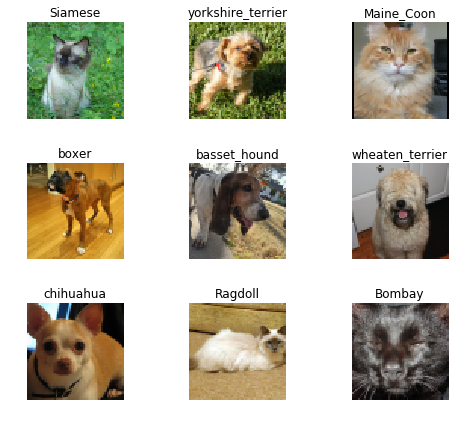

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,4.203142,3.641876,1.000000


### data block

In [118]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='cat1')
        .transform(tfms, size=64)).databunch()

/Users/yang.zhang/git/fastai/fastai/data_block.py:497: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
american_bulldog
  if getattr(ds, 'warn', False): warn(ds.warn)


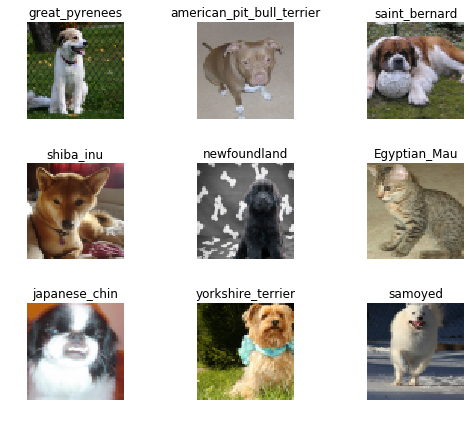

In [119]:
data.show_batch(rows=3, figsize=(7,6))

In [120]:
src=(ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))

In [17]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,4.153660,4.150504,1.000000


## multiclass 

In [70]:
df=df_full[['img', 'mcat1', 'is_valid']]
df.head()

,img,mcat1,is_valid
0,pug_106,x z,False
1,japanese_chin_35,x,False
2,Bombay_157,x,False
3,British_Shorthair_98,z x,False
4,american_bulldog_23,,False


### databunch factory method

In [71]:
data = ImageDataBunch.from_df(path, df, folder='images', suffix='.jpg', size=64, label_delim=' ')

> /Users/yang.zhang/git/fastai/fastai/data_block.py(238)_label_from_list()
-> y = label_cls(labels, path=self.path, **kwargs)
(Pdb) label_cls
<class 'fastai.data_block.MultiCategoryList'>
(Pdb) labels
array(['x', 'x', 'z x', 'z y', ..., '', 'z y', '', 'z'], dtype=object)
(Pdb) kwargs
{'label_delim': ' '}
(Pdb) q


BdbQuit: 

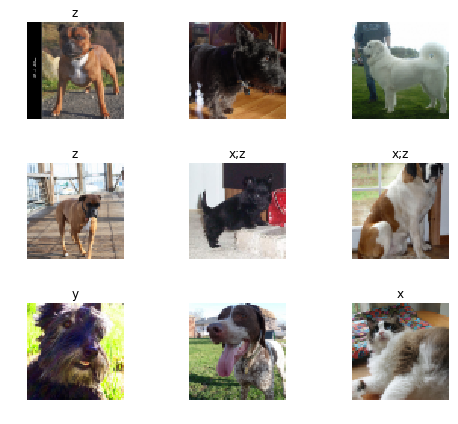

In [23]:
data.show_batch(rows=3, figsize=(7,6))

In [24]:
learn = create_cnn(data, models.resnet18)
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss
1,0.837814,0.742480


### data block

In [26]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='mcat1', label_delim=' ')
        .transform(tfms, size=64)).databunch()

In [ ]:
# debug
src=(ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))
def dbg():
    breakpoint()
    src.label_from_df(cols='mcat1', label_delim=' ')
dbg()

In [29]:
learn = create_cnn(data, models.resnet18)
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [30]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss
1,0.811517,0.737025


## regression

In [31]:
df=df_full[['img', 'num1', 'is_valid']]
df.head()

,img,num1,is_valid
0,pug_106,0.851944,False
1,japanese_chin_35,0.768339,False
2,Bombay_157,0.554693,False
3,British_Shorthair_98,0.733173,False
4,american_bulldog_23,-1.104222,False


### databunch factory method

In [32]:
# doesn't work
# data = ImageDataBunch.from_df(path, df[['img', 'num1']], folder='images', suffix='.jpg', size=64)

### data block

In [33]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='num1')
        .transform(tfms, size=64)).databunch()

In [34]:
learn = create_cnn(data, models.resnet18, metrics=mse)
learn.loss_func

FlattenedLoss of MSELoss()

In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,mean_squared_error
1,1.831803,1.286596,1.286596


# multi task

https://docs.fast.ai/tutorial.itemlist.html

## 2 single-classes

In [12]:
df=df_full[['img', 'cat1', 'cat2', 'is_valid']]
df.head()

,img,cat1,cat2,is_valid
0,american_bulldog_218,american_bulldog,A,False
1,japanese_chin_174,japanese_chin,B,False
2,basset_hound_46,basset_hound,A,False
3,havanese_183,havanese,A,False
4,newfoundland_103,newfoundland,A,False


In [13]:
src = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))

type(src), type(src.train)

(fastai.data_block.ItemLists, fastai.vision.data.ImageItemList)

In [14]:
class MultitaskProcessor(PreProcessor):
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes_cat1, ds.classes_cat2)
        self.warns = []

    def create_classes(self, classes_cat1, classes_cat2):
        self.classes_cat1,self.classes_cat2 = classes_cat1,classes_cat2
        self.c2i_cat1 = {v:k for k,v in enumerate(classes_cat1)}
        self.c2i_cat2 = {v:k for k,v in enumerate(classes_cat2)}

    def process_one(self,item):
        if isinstance(item, EmptyLabel): return item
        res_cat1 = self.c2i_cat1.get(item[0],None)
        res_cat2 = self.c2i_cat2.get(item[1],None)
        if res_cat1 is None or res_cat2 is None: self.warns.append(str(item))
        return res_cat1,res_cat2

    def process(self, ds):
        ds.c2i_cat1 = self.c2i_cat1
        ds.c2i_cat1 = self.c2i_cat1
        super().process(ds)


class MultitaskList(ItemList):
    _processor=MultitaskProcessor
    def __init__(self, items, **kwargs):
        self.classes_cat1=sorted(set(np.array(items)[:,0]))
        self.classes_cat2=sorted(set(np.array(items)[:,1]))
        self.c_cat1,self.c_cat2=len(self.classes_cat1), len(self.classes_cat2)
        self.filter_missing_y=True
        super().__init__(items, **kwargs)
#         self.copy_new.append('classes_cat1')
#         self.copy_new.append('classes_cat2')
    @property
    def c(self): return self.c_cat1+self.c_cat2

In [15]:
from types import MethodType
def label_from_df_mtsk(self, label_cls=MultitaskList, **kwargs):
    labels = self.inner_df[['cat1', 'cat2']]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it." 
    return self._label_from_list(labels.values, label_cls, **kwargs)

for ll in (src.train, src.valid):
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)

In [16]:
src = src.label_from_df_mtsk()
src

LabelLists;

Train: LabelList (86 items)
x: ImageItemList
Image (3, 500, 449),Image (3, 500, 395),Image (3, 375, 500),Image (3, 500, 334),Image (3, 375, 500)
y: MultitaskList
[10  0],[21  1],[12  0],[20  0],[25  0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (14 items)
x: ImageItemList
Image (3, 333, 500),Image (3, 480, 374),Image (3, 181, 300),Image (3, 500, 334),Image (3, 375, 500)
y: MultitaskList
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [17]:
src.train.y.c_cat1, src.train.y.c_cat2, src.train.y.c

(34, 2, 36)

In [18]:
src = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))
for ll in (src.train, src.valid):
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
src = src.label_from_df_mtsk()
src

LabelLists;

Train: LabelList (86 items)
x: ImageItemList
Image (3, 500, 449),Image (3, 500, 395),Image (3, 375, 500),Image (3, 500, 334),Image (3, 375, 500)
y: MultitaskList
[10  0],[21  1],[12  0],[20  0],[25  0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (14 items)
x: ImageItemList
Image (3, 333, 500),Image (3, 480, 374),Image (3, 181, 300),Image (3, 500, 334),Image (3, 375, 500)
y: MultitaskList
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [19]:
src.valid.y

MultitaskList (14 items)
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet

In [20]:
src=src.transform(tfms, size=64)
src

LabelLists;

Train: LabelList (86 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[10  0],[21  1],[12  0],[20  0],[25  0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (14 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [21]:
src

LabelLists;

Train: LabelList (86 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[10  0],[21  1],[12  0],[20  0],[25  0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (14 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [22]:
src.databunch()

ImageDataBunch;

Train: LabelList (86 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[10  0],[21  1],[12  0],[20  0],[25  0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (14 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[29 1],[2 0],[1 0],[7 1],[30 1]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [24]:
data = src.databunch()

In [29]:
data.show_batch(rows=3, figsize=(7,6))

AttributeError: 'numpy.ndarray' object has no attribute 'reconstruct'

In [ ]:
%debug

> /Users/yang.zhang/git/fastai/fastai/data_block.py(89)reconstruct()
     87     def reconstruct(self, t:Tensor, x:Tensor=None):
     88         "Reconstruct one of the underlying item for its data `t`."
---> 89         return self[0].reconstruct(t,x) if has_arg(self[0].reconstruct, 'x') else self[0].reconstruct(t)
     90 
     91     def new(self, items:Iterator, processor:PreProcessors=None, **kwargs)->'ItemList':



In [27]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)
learn.loss_func

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate


RuntimeError: multi-target not supported at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.7/pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:21